# Product Demand Forecasts
The dataset contains historical product demand for a manufacturing company with footprints globally. The company provides thousands of products within dozens of product categories. There are four central warehouses to ship products within the region it is responsible for. Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. If forecasts for each product in different central with reasonable accuracy for the monthly demand for month after next can be achieved, it would be beneficial to the company in multiple ways.

Dataset Link: https://www.kaggle.com/datasets/felixzhao/productdemandforecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import calendar
import optuna
import warnings

from datetime import datetime, date
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

warnings.simplefilter('ignore')
#pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10000)

In [2]:
df = pd.read_csv("Data/Historical_Product_Demand.csv")
df.head(5)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


## Check for NaNs in columns and drop those rows

In [3]:
print (df.isna().sum())
df.dropna(axis=0, inplace=True) #remove all rows with na's.
df.reset_index(drop=True)
print (df.isna().sum())

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64
Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64


# Circular encoding of month

In [4]:
# Convert order demand column to int
def str2num(val):
    num = re.findall(r'\d+', val)
    return float(''.join(num))

def month_year_extract(date_str):
    date_obj = datetime.strptime(date_str, '%Y/%m/%d')
    return date(date_obj.year, date_obj.month, 1)

def month_nr_extract(date_str):
    date_obj = datetime.strptime(date_str, '%Y/%m/%d')
    return date_obj.month

def month_name_extract(date_str):
    date_obj = datetime.strptime(date_str, '%Y/%m/%d')
    return calendar.month_name[date_obj.month]
    
def year_extract(date_str):
    date_obj = datetime.strptime(date_str, '%Y/%m/%d')
    return date_obj.year
    
def month_circular_encoding_sin(date_str):
    date_obj = datetime.strptime(date_str, '%Y/%m/%d')
    return np.sin(2 * np.pi * float(date_obj.month)/12)

def month_circular_encoding_cos(date_str):
    date_obj = datetime.strptime(date_str, '%Y/%m/%d')
    return np.cos(2 * np.pi * float(date_obj.month)/12)

In [5]:
df.loc[:,"Order_Demand"] = df.loc[:,"Order_Demand"].apply(str2num)
df = df.astype({'Order_Demand': 'int32'},copy=True)

df["month_year"] = df["Date"].apply(month_year_extract)
df["month_nr"] = df["Date"].apply(month_nr_extract)
df["month"] = df["Date"].apply(month_name_extract)
df["year"] = df["Date"].apply(year_extract)
#df["day_sin"] = df["Date"].apply(month_circular_encoding_sin)
#df["day_cos"] = df["Date"].apply(month_circular_encoding_cos)
df["month_sin"] = df["Date"].apply(month_circular_encoding_sin)
df["month_cos"] = df["Date"].apply(month_circular_encoding_cos)
df.drop(columns=['Date'], inplace=True)

display(df.info())
display(df.head(5))
display(df.nunique())

<class 'pandas.core.frame.DataFrame'>
Index: 1037336 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Product_Code      1037336 non-null  object 
 1   Warehouse         1037336 non-null  object 
 2   Product_Category  1037336 non-null  object 
 3   Order_Demand      1037336 non-null  int32  
 4   month_year        1037336 non-null  object 
 5   month_nr          1037336 non-null  int64  
 6   month             1037336 non-null  object 
 7   year              1037336 non-null  int64  
 8   month_sin         1037336 non-null  float64
 9   month_cos         1037336 non-null  float64
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 83.1+ MB


None

,Product_Code,Warehouse,Product_Category,Order_Demand,month_year,month_nr,month,year,month_sin,month_cos
0,Product_0993,Whse_J,Category_028,100,2012-07-01,7,July,2012,-0.500000,-8.660254e-01
1,Product_0979,Whse_J,Category_028,500,2012-01-01,1,January,2012,0.500000,8.660254e-01
2,Product_0979,Whse_J,Category_028,500,2012-02-01,2,February,2012,0.866025,5.000000e-01
3,Product_0979,Whse_J,Category_028,500,2012-02-01,2,February,2012,0.866025,5.000000e-01
4,Product_0979,Whse_J,Category_028,500,2012-03-01,3,March,2012,1.000000,6.123234e-17


Product_Code        2160
Warehouse              4
Product_Category      33
Order_Demand        3309
month_year            68
month_nr              12
month                 12
year                   7
month_sin             11
month_cos             11
dtype: int64

In [6]:
# Objective function for hyperparameter tuning of DecisionTree
random_state = 42
def objective_dtr(trial, X_train, X_valid, y_train, y_valid):
    params = {
    "criterion": trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse"]),
    "splitter": trial.suggest_categorical("splitter", ["best", "random"]),
    "max_depth": trial.suggest_int("max_depth", 1, 10),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
    "random_state": trial.suggest_categorical("random_state", [random_state])
    }
    
    model = DecisionTreeRegressor(**params).fit(X_train, y_train)
    r2 = model.score(X_valid, y_valid)
    #y_predicted = model.predict(X_valid)
    #rmse = mean_squared_error(y_valid, y_predicted, squared=False)
    
    return r2

In [7]:
# Objective function for hyperparameter tuning of RandomForest
random_state = 42
def objective_rfr(trial, X_train, X_valid, y_train, y_valid):
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 10, 250, step = 10),
    "max_depth": trial.suggest_int("max_depth", 1, 15),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    "criterion": trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse"]),
    "random_state": trial.suggest_categorical("random_state", [random_state]),
    "n_jobs": trial.suggest_categorical("n_jobs", [-1])
    }
    
    model = RandomForestRegressor(**params).fit(X_train, y_train)
    r2 = model.score(X_valid, y_valid)
    #y_predicted = model.predict(X_valid)
    #rmse = mean_squared_error(y_valid, y_predicted, squared=False)
    
    return r2

In [8]:
# Objective function for hyperparameter tuning of Support Vector Machine
def objective_svr(trial, X_train, X_valid, y_train, y_valid):
    params = {
    "C": trial.suggest_float("C", 1e-10, 1e10, log=True),
    "kernel": trial.suggest_categorical("kernel", ["linear", "rbf", "sigmoid"]),
    "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
    "max_iter": trial.suggest_categorical("max_iter", [1000*1000]),
    }
    
    model = SVR(**params).fit(X_train, y_train)
    r2 = model.score(X_valid, y_valid)
    #y_predicted = model.predict(X_valid)
    #rmse = mean_squared_error(y_valid, y_predicted, squared=False)
    
    return r2

## Predict based on Product Category

In [9]:
# Loop through product categories and train a regression model for each category
agg_dict = {'month_nr':['mean'], 'month_sin':['mean'], 'month_cos':['mean'], 'Order_Demand':['sum']}

product_categories = df["Product_Category"].unique()
display(product_categories)
r2_vals = {'category':[],'regressor':[], 'r2':[]}
for idx, category in enumerate(product_categories):
    rows_sel = (df['Product_Category'] == category) & (df['year'] > 2011) & (df['year'] < 2017)
    print(f"Nr. Entrees for category = {sum(rows_sel)}")
    df_selected = df[rows_sel]
    
    grouped_data = df_selected[['year', 'month', 'month_nr', 'month_sin', 'month_cos','Order_Demand']].sort_values(['month_nr'],ascending=True).groupby(['year', 'month']).agg(agg_dict)
    
    X = grouped_data[['month_sin', 'month_cos']]
    y = grouped_data[['Order_Demand']].values.ravel()

    #display(X)
    #display(y)
    X = X.values
    y = y.ravel()
    #display(X)
    #display(y)

    X = StandardScaler().fit_transform(X)
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1, random_state=0)

    dectree_r2  =0
    randfor_r2 = 0

    optuna.logging.set_verbosity(optuna.logging.INFO)
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    # DecisionTreeRegressor
    study_dtr = optuna.create_study(direction = "maximize")
    func = lambda trial: objective_dtr(trial, X_train, X_valid, y_train, y_valid)
    study_dtr.optimize(func, n_trials = 100, timeout=600)
    model = DecisionTreeRegressor(**study_dtr.best_trial.params).fit(X_train_valid, y_train_valid)
    dectree_r2 = model.score(X_test, y_test)

    # RandomForestRegressor
    study_rfr = optuna.create_study(direction = "maximize")
    func = lambda trial: objective_rfr(trial, X_train, X_valid, y_train, y_valid)
    study_rfr.optimize(func, n_trials = 100, timeout=600)
    model = RandomForestRegressor(**study_rfr.best_trial.params).fit(X_train_valid, y_train_valid)
    randfor_r2 = model.score(X_test, y_test)

    # SVR
    study_svr = optuna.create_study(direction = "maximize")
    func = lambda trial: objective_svr(trial, X_train, X_valid, y_train, y_valid)
    study_svr.optimize(func, n_trials = 100, timeout=600)
    model = SVR(**study_svr.best_trial.params).fit(X_train_valid, y_train_valid)
    svr_r2 = model.score(X_test, y_test)

    if dectree_r2 > 0 or randfor_r2 > 0 or svr_r2 > 0:
        r2_vals['category'].append(category)
        r2_vals['regressor'].append("DecisionTreeRegressor")
        r2_vals['r2'].append(dectree_r2)
    
        r2_vals['category'].append(category)
        r2_vals['regressor'].append("RandomForestRegressor")
        r2_vals['r2'].append(randfor_r2)
    
        r2_vals['category'].append(category)
        r2_vals['regressor'].append("SVR")
        r2_vals['r2'].append(svr_r2)

        print(f"{category}, DecisionTree R2 = {dectree_r2}")
        print(f"{category}, RandomForest R2 = {randfor_r2}")
        print(f"{category}, SVR R2 = {svr_r2}")

array(['Category_028', 'Category_006', 'Category_001', 'Category_019',
       'Category_005', 'Category_030', 'Category_032', 'Category_011',
       'Category_033', 'Category_007', 'Category_015', 'Category_021',
       'Category_024', 'Category_026', 'Category_023', 'Category_022',
       'Category_009', 'Category_003', 'Category_004', 'Category_018',
       'Category_020', 'Category_013', 'Category_008', 'Category_017',
       'Category_031', 'Category_025', 'Category_010', 'Category_029',
       'Category_012', 'Category_002', 'Category_014', 'Category_027',
       'Category_016'], dtype=object)

Nr. Entrees for category = 30957
Nr. Entrees for category = 35495
Category_006, DecisionTree R2 = 0.005726103487661116
Category_006, RandomForest R2 = -0.19307476682890656
Category_006, SVR R2 = -0.42440783985256236
Nr. Entrees for category = 97707
Nr. Entrees for category = 470090
Nr. Entrees for category = 101582
Category_005, DecisionTree R2 = 0.04608748118118189
Category_005, RandomForest R2 = -0.08519484650966147
Category_005, SVR R2 = 0.07382753332578662
Nr. Entrees for category = 12978
Nr. Entrees for category = 9288
Nr. Entrees for category = 23199
Nr. Entrees for category = 1849
Nr. Entrees for category = 82348
Nr. Entrees for category = 22937
Category_015, DecisionTree R2 = -0.175940299931441
Category_015, RandomForest R2 = 0.048279593151561606
Category_015, SVR R2 = -9.899887565166376
Nr. Entrees for category = 51950
Nr. Entrees for category = 20863
Nr. Entrees for category = 14763
Nr. Entrees for category = 7885
Category_023, DecisionTree R2 = 0.34807374833630156
Category_0

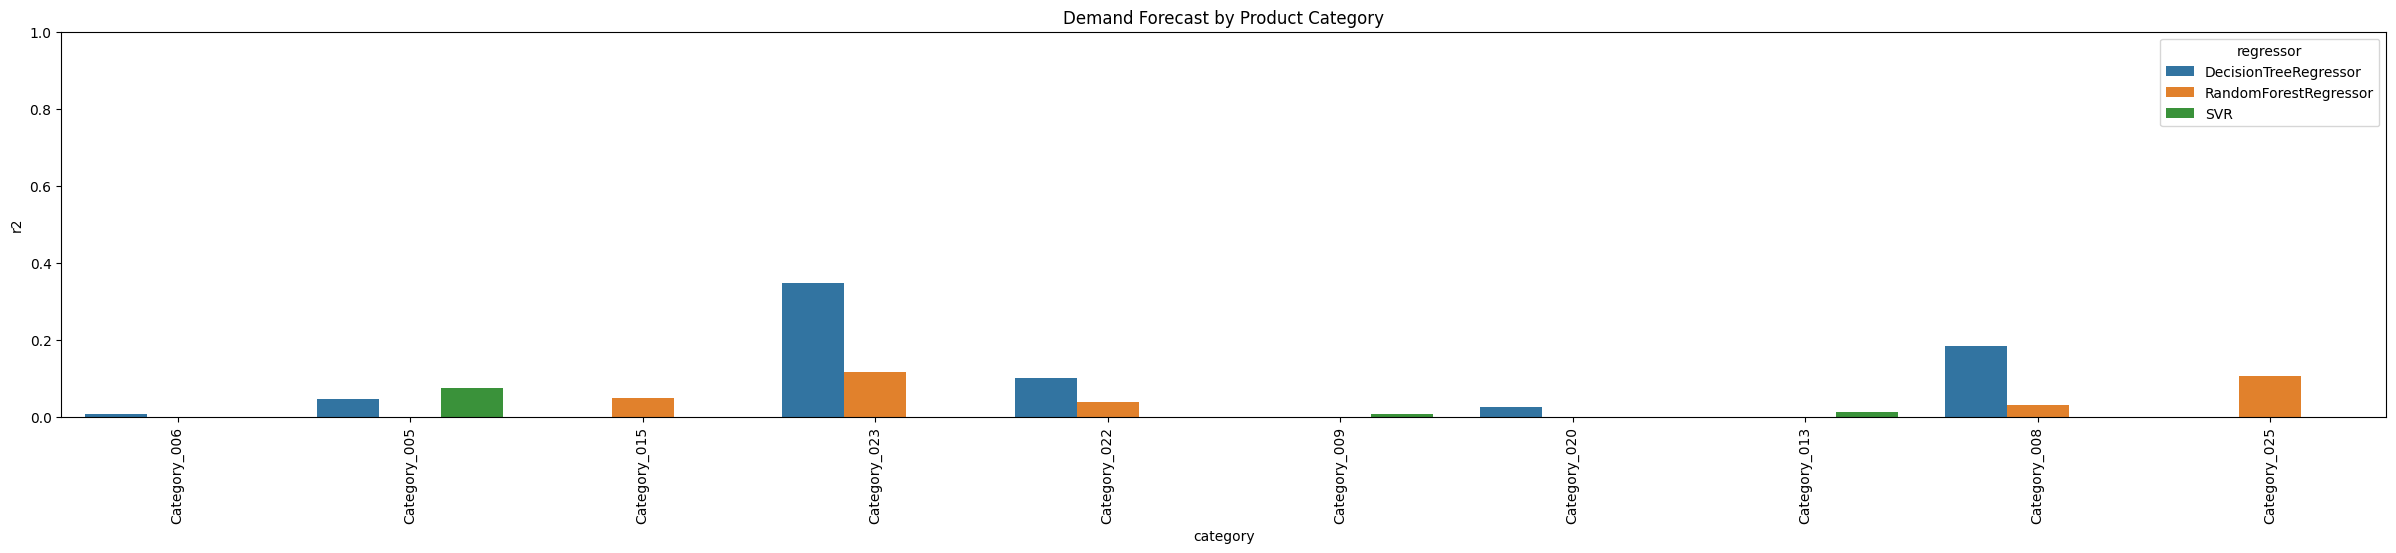

In [10]:
category_demand_prediction_df = pd.DataFrame(data=r2_vals)
plt.figure(figsize=(30, 5))
sns.barplot(category_demand_prediction_df, x="category", y="r2", hue="regressor")
plt.xticks(rotation=90) 
plt.ylim(0, 1)
plt.title("Demand Forecast by Product Category")
plt.savefig("Images/Product_Demand_Forecasts_by_Product_Category.png")

## Predict based on Product Code

In [11]:
# Loop through product categories and train a regression model for each category
agg_dict = {'month_nr':['mean'], 'month_sin':['mean'], 'month_cos':['mean'], 'Order_Demand':['sum']}

product_codes = df["Product_Code"].unique()
display(product_codes)
r2_vals = {'product':[],'regressor':[], 'r2':[]}
for idx, prod_code in enumerate(product_codes):
    rows_sel = (df['Product_Code'] == prod_code) & (df['year'] > 2011) & (df['year'] < 2017)
    nr_entrees = sum(rows_sel)
    print(f"Nr. Entrees for Product_Code = {nr_entrees}")

    if nr_entrees > 1000:
        df_selected = df[rows_sel]
        
        grouped_data = df_selected[['year', 'month', 'month_nr', 'month_sin', 'month_cos','Order_Demand']].sort_values(['month_nr'],ascending=True).groupby(['year', 'month']).agg(agg_dict)
        
        X = grouped_data[['month_sin', 'month_cos']]
        y = grouped_data[['Order_Demand']].values.ravel()
    
        #display(X)
        #display(y)
        X = X.values
        y = y.ravel()
        #display(X)
        #display(y)
    
        X = StandardScaler().fit_transform(X)
        X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1, random_state=0)
    
        dectree_r2  =0
        randfor_r2 = 0
    
        optuna.logging.set_verbosity(optuna.logging.INFO)
        optuna.logging.set_verbosity(optuna.logging.WARNING)
    
        # DecisionTreeRegressor
        study_dtr = optuna.create_study(direction = "maximize")
        func = lambda trial: objective_dtr(trial, X_train, X_valid, y_train, y_valid)
        study_dtr.optimize(func, n_trials = 100, timeout=600)
        model = DecisionTreeRegressor(**study_dtr.best_trial.params).fit(X_train_valid, y_train_valid)
        dectree_r2 = model.score(X_test, y_test)
    
        # RandomForestRegressor
        study_rfr = optuna.create_study(direction = "maximize")
        func = lambda trial: objective_rfr(trial, X_train, X_valid, y_train, y_valid)
        study_rfr.optimize(func, n_trials = 100, timeout=600)
        model = RandomForestRegressor(**study_rfr.best_trial.params).fit(X_train_valid, y_train_valid)
        randfor_r2 = model.score(X_test, y_test)
    
        # SVR
        study_svr = optuna.create_study(direction = "maximize")
        func = lambda trial: objective_svr(trial, X_train, X_valid, y_train, y_valid)
        study_svr.optimize(func, n_trials = 100, timeout=600)
        model = SVR(**study_svr.best_trial.params).fit(X_train_valid, y_train_valid)
        svr_r2 = model.score(X_test, y_test)
    
        if dectree_r2 > 0 or randfor_r2 > 0 or svr_r2 > 0:
            r2_vals['product'].append(prod_code)
            r2_vals['regressor'].append("DecisionTreeRegressor")
            r2_vals['r2'].append(dectree_r2)
        
            r2_vals['product'].append(prod_code)
            r2_vals['regressor'].append("RandomForestRegressor")
            r2_vals['r2'].append(randfor_r2)
        
            r2_vals['product'].append(prod_code)
            r2_vals['regressor'].append("SVR")
            r2_vals['r2'].append(svr_r2)
    
            print(f"{prod_code}, DecisionTree R2 = {dectree_r2}")
            print(f"{prod_code}, RandomForest R2 = {randfor_r2}")
            print(f"{prod_code}, SVR R2 = {svr_r2}")

Product_1420, DecisionTree R2 = 0.3549853771120033
Product_1420, RandomForest R2 = 0.4270824255340875
Product_1420, SVR R2 = 0.3184663111501428
Nr. Entrees for Product_Code = 2508


[W 2024-01-09 23:05:37,810] Trial 30 failed with parameters: {'criterion': 'squared_error', 'splitter': 'random'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\DLP\miniconda3\envs\elpi\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\DLP\AppData\Local\Temp\ipykernel_43556\3711346886.py", line 39, in <lambda>
    func = lambda trial: objective_dtr(trial, X_train, X_valid, y_train, y_valid)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\DLP\AppData\Local\Temp\ipykernel_43556\3233098250.py", line 7, in objective_dtr
    "max_depth": trial.suggest_int("max_depth", 1, 10),
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\DLP\miniconda3\envs\elpi\Lib\site-packages\optuna\_convert_positional_args.py", line 83, in converter_wrapper
    return func(**kwargs)


KeyboardInterrupt: 

In [ ]:
product_demand_prediction_df = pd.DataFrame(data=r2_vals)
product_demand_prediction_df
plt.figure(figsize=(30, 5))
sns.barplot(product_demand_prediction_df, x="product", y="r2", hue="regressor")
plt.xticks(rotation=90) 
plt.ylim(0, 1)
plt.grid(visible=True, which='both', axis='y')
plt.title("Demand Forecast by Product")
plt.savefig("Images/Product_Demand_Forecasts_by_Product.png")